In [8]:
# !git clone --recursive https://github.com/microsoft/LightGBM
# !cd LightGBM
# !mkdir build
# !cd build
# !cmake -DUSE_CUDA=1 ..
# !make -j4

In [68]:
import os
import pickle
import wandb
import warnings
# from utility import *

environment = 'local'
if environment == 'paperspace':
    os.chdir('/notebooks/Scripts')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PolynomialFeatures, SplineTransformer, KBinsDiscretizer, \
     StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression, r_regression, mutual_info_regression, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score, get_scorer_names, accuracy_score, f1_score, precision_score, \
     confusion_matrix, recall_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, cross_validate, TimeSeriesSplit
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor, LocalOutlierFactor
import sklearn.linear_model as lm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from hyperparams import *

from imblearn.under_sampling import NearMiss, CondensedNearestNeighbour, TomekLinks
# from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.combine import SMOTETomek, SMOTEENN

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

RANDOM_STATE = 42
warnings.filterwarnings('ignore')
wandb.login()

True

In [18]:
run = wandb.init(
  project="Dream11", entity=None, job_type="modeling",
  notes="Modelling the Dream11 dataset (~40 games) with XGBClassifier (5 classes) w/o feature embeddings",
  tags = ['undersample', 'xgboost', '5_classes', 'no_embeddings', 'n_iter100'],
)

In [216]:
if environment == 'local':
    train = pd.read_csv('../Inputs/ball-by-ball prediction/main_5c.csv')
    # train = pd.read_csv('../Inputs/ball-by-ball prediction/embfeats10K.csv')
else:
    train = pd.read_csv('embfeats10K.csv')
    train = pd.read_csv('main.csv')

In [217]:
labels = train.target.unique().tolist()

In [227]:
df = train[:10000].copy()
df['cluster'] = X.cluster

In [228]:
def get_train_test_split(df, target = 'target', test_size=0.1):
    le = LabelEncoder()
    X, y = df.drop(target, axis=1), le.fit_transform(df[target])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=RANDOM_STATE)
    return X_train, X_test, y_train, y_test

In [229]:
X_train, X_test, y_train, y_test = get_train_test_split(df)

In [232]:
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()
cat_features = cat_features + ['cluster']
num_features = X_train.drop(columns=cat_features).select_dtypes(exclude=['object']).columns

In [233]:
len(num_features), num_features, cat_features

(21,
 Index(['innings', 'overs', 'balls', 'bat_0_runs', 'bat_1_runs', 'bat_2_runs',
        'bat_3_runs', 'bat_4_runs', 'bat_6_runs', 'bat_num_dismissals',
        'bat_wides', 'bat_total_balls', 'bowl_0_runs', 'bowl_1_runs',
        'bowl_2_runs', 'bowl_3_runs', 'bowl_4_runs', 'bowl_6_runs',
        'bowl_num_dismissals', 'bowl_wides', 'bowl_total_balls'],
       dtype='object'),
 ['venue',
  'batting_team',
  'bowling_team',
  'striker',
  'non_striker',
  'bowler',
  'cluster'])

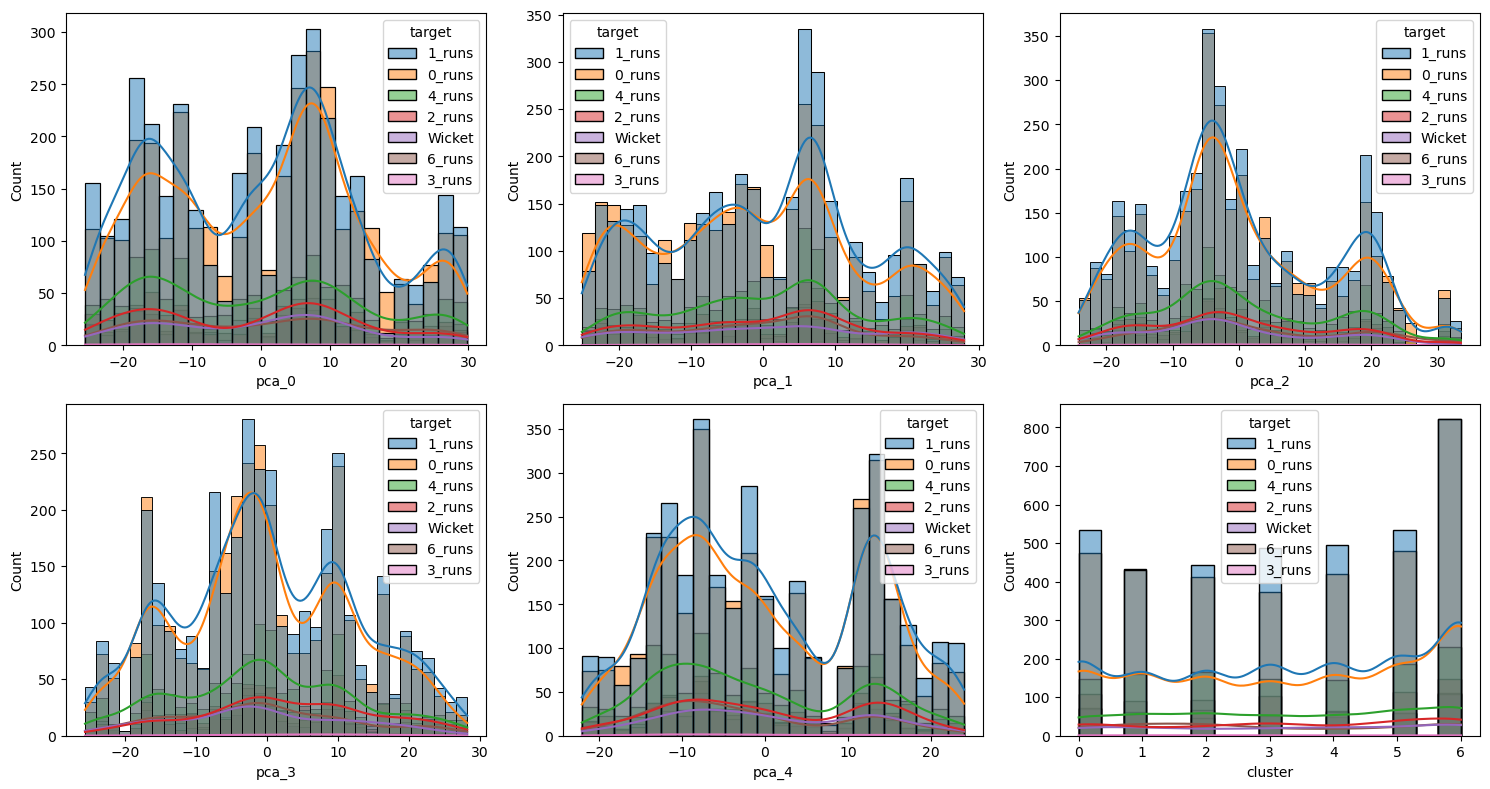

In [154]:
# assuming numerical features are stored in a list called "numerical_features"
num_cols = 3 # number of columns in the subplot grid
num_rows = (len(num_features) + num_cols - 1) // num_cols # number of rows in the subplot grid

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 4*num_rows)) # create the subplot grid

for i, feature in enumerate(num_features):
    row = i // num_cols
    col = i % num_cols
    sns.histplot(data=X, x=feature, hue='target', kde=True, ax=axs[row, col]) # plot the histogram

plt.tight_layout() # adjust spacing between subplots
plt.show()


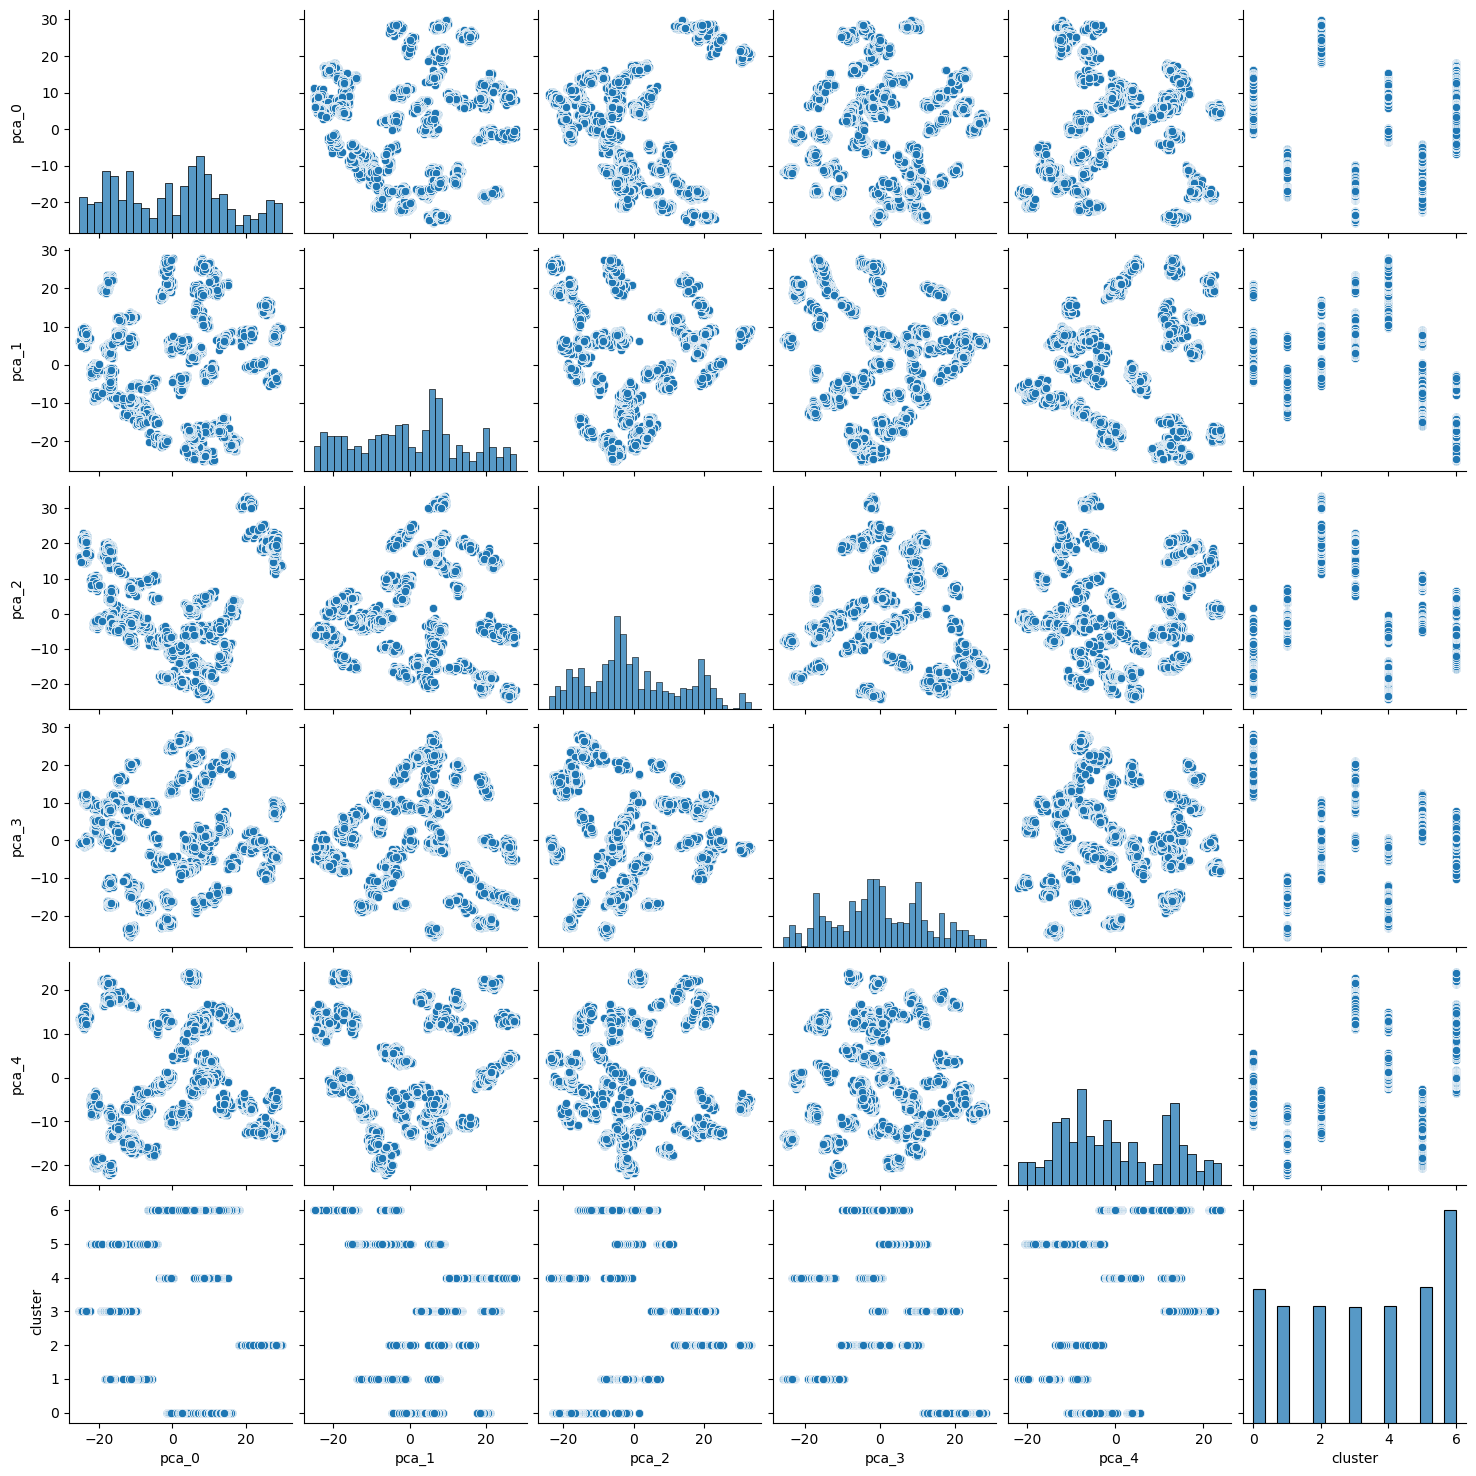

In [130]:
# subset = ['bat_0_runs', 'bat_1_runs', 'bat_2_runs', 'bat_3_runs', 'bat_4_runs', 'bat_6_runs']

# Create a pairplot for the subset
sns.pairplot(X)
plt.show()

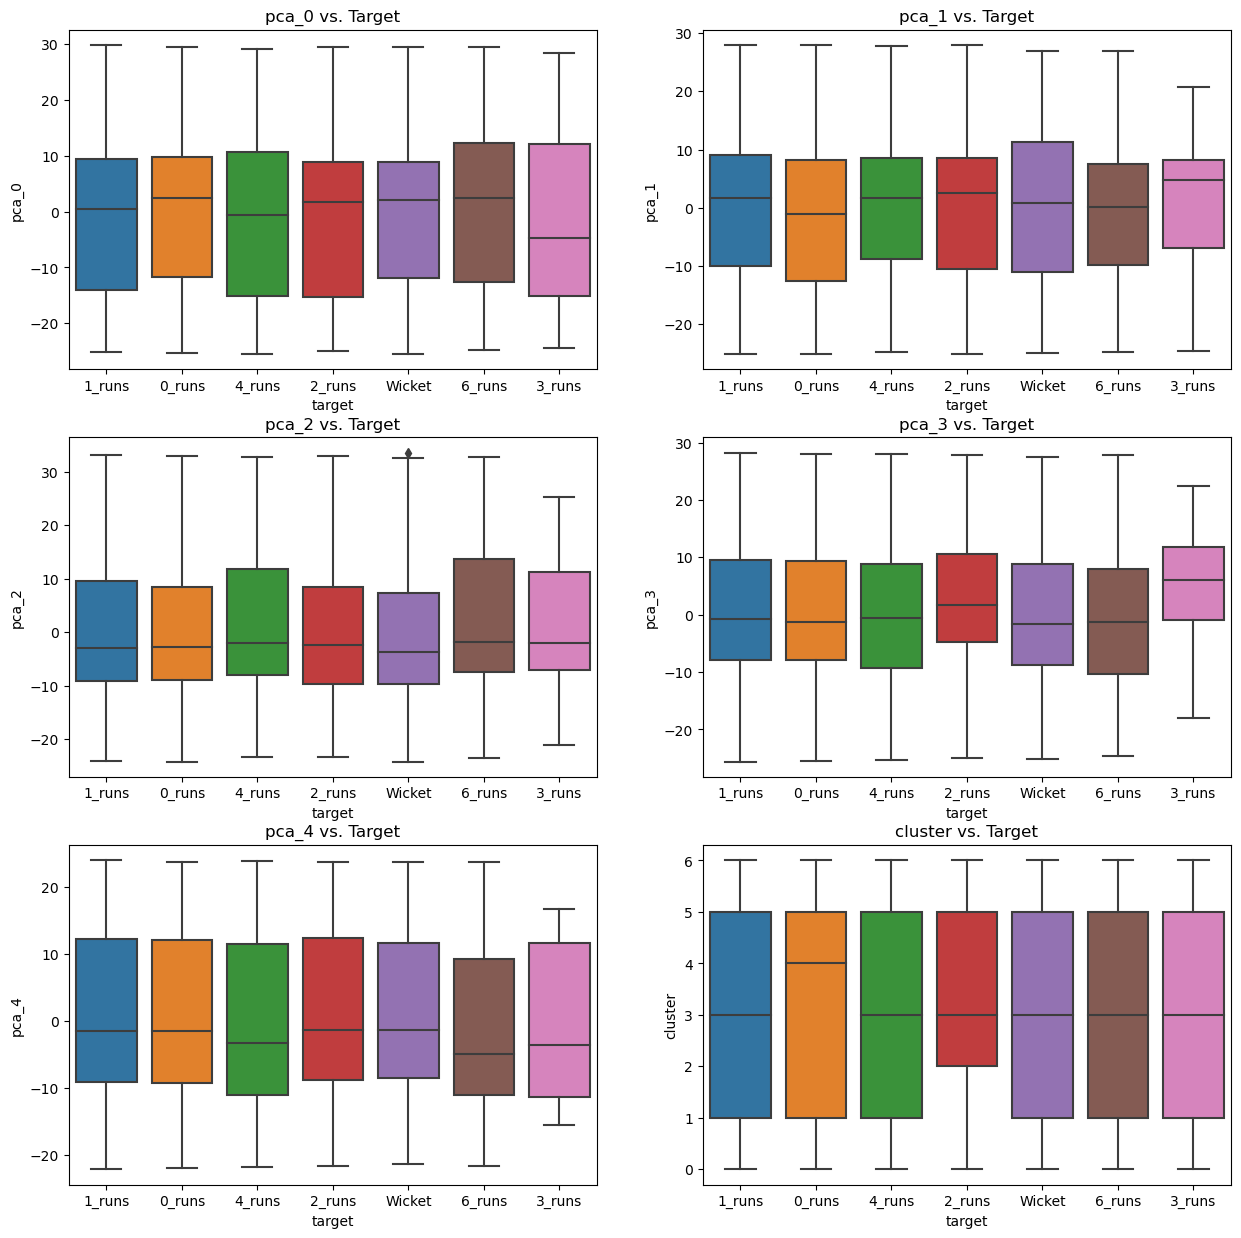

In [133]:
# create subplots for each numerical feature
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

# loop through each subplot and create a boxplot of the target variable vs. the numerical feature
for i, ax in enumerate(axes.flatten()):
    sns.boxplot(x='target', y=num_features[i], data=X, ax=ax)
    ax.set_title(f'{num_features[i]} vs. Target')
    
# display the plot
plt.show()

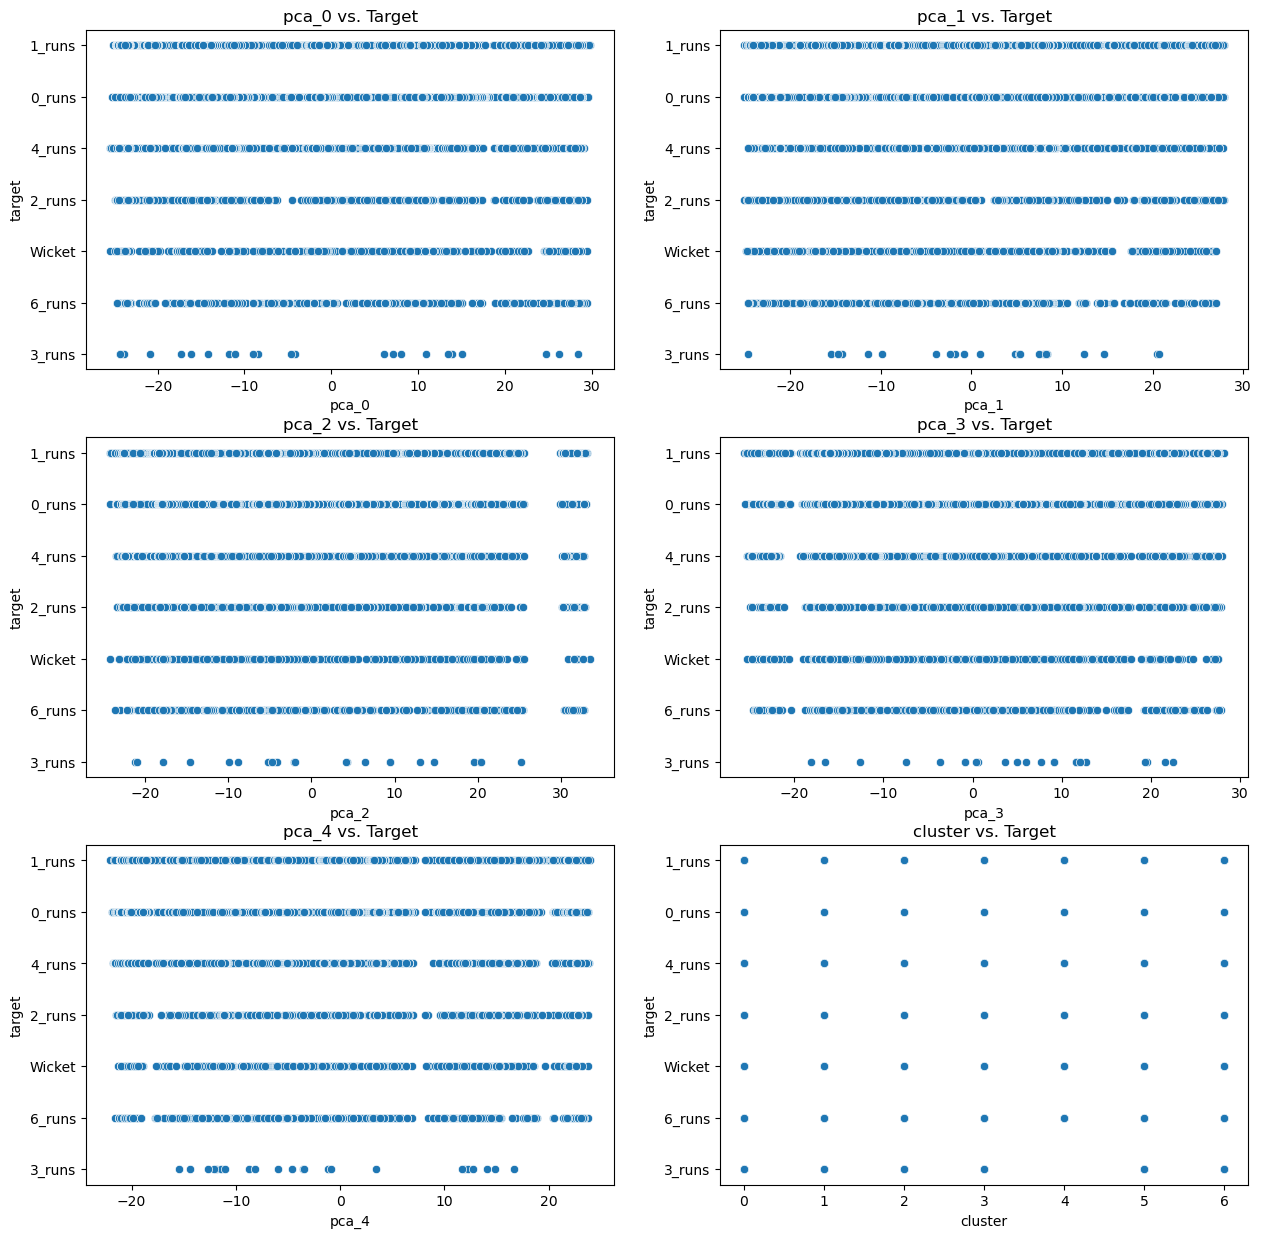

In [135]:
# create subplots for each numerical feature
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

# loop through each subplot and create a scatterplot of the numerical feature vs. the target variable
for i, ax in enumerate(axes.flatten()):
    sns.scatterplot(x=num_features[i], y='target', data=X, ax=ax)
    ax.set_title(f'{num_features[i]} vs. Target')
    
# display the plot
plt.show()



In [188]:
X = preprocessor.fit_transform(train.drop('target', axis=1))

In [189]:
X.shape

(10000, 42)

In [192]:
model = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=500)
tsne = model.fit_transform(X)

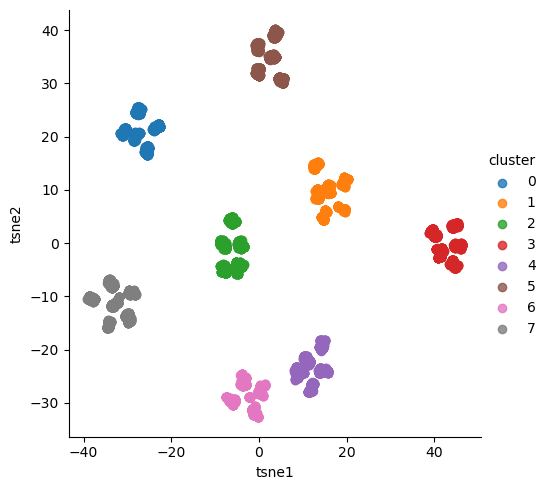

In [194]:
# pca = PCA(n_components=0.50)
# pca.fit(X)
# pc = pca.transform(X)
kmeans = KMeans(n_clusters=8, algorithm='lloyd', random_state=RANDOM_STATE)
kmeans.fit(X)

fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
# print(np.sum(pca.explained_variance_ratio_))

In [195]:
#add cluster to train
X = pd.DataFrame(X, columns=[f'pca_{i}' for i in range(X.shape[1])])

In [196]:
#add cluster to train
X['cluster'] = kmeans.labels_

In [197]:
X['target'] = train.target

In [207]:
X.to_csv('../Inputs/ball-by-ball prediction/embfeats10K_pca_clustering.csv', index=False)

In [87]:
cat_features, num_features

(Index(['venue', 'batting_team', 'bowling_team', 'striker', 'non_striker',
        'bowler'],
       dtype='object'),
 Index(['innings', 'overs', 'balls', 'bat_0_runs', 'bat_1_runs', 'bat_2_runs',
        'bat_3_runs', 'bat_4_runs', 'bat_6_runs', 'bat_num_dismissals',
        'bat_wides', 'bat_total_balls', 'bowl_0_runs', 'bowl_1_runs',
        'bowl_2_runs', 'bowl_3_runs', 'bowl_4_runs', 'bowl_6_runs',
        'bowl_num_dismissals', 'bowl_wides', 'bowl_total_balls'],
       dtype='object'))

In [253]:
numeric_transformer = imbPipeline([
      ("poly", PolynomialFeatures(degree=2)),
      ("splines", SplineTransformer()),
      ("scaler", StandardScaler()),
      ("bins", KBinsDiscretizer(encode="ordinal")),
      ("feats", SelectFromModel(lm.Lasso(random_state=RANDOM_STATE)))
      # ('pca', PCA(n_components=0.94))
])

categorical_transformer = imbPipeline([
      ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
])

In [254]:
preprocessor = ColumnTransformer(
    transformers=[
        # ('new_feats', CustomFeatureTransformer(), num_features),
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

In [255]:
#Randomized Search CV - LGBM
pipe = imbPipeline([
    ('prep', preprocessor),
    ('undersample', TomekLinks()),
    ('clf', XGBClassifier(booster='gbtree', tree_method='hist', random_state=RANDOM_STATE))
])
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'prep', 'undersample', 'clf', 'prep__n_jobs', 'prep__remainder', 'prep__sparse_threshold', 'prep__transformer_weights', 'prep__transformers', 'prep__verbose', 'prep__verbose_feature_names_out', 'prep__num', 'prep__cat', 'prep__num__memory', 'prep__num__steps', 'prep__num__verbose', 'prep__num__poly', 'prep__num__splines', 'prep__num__scaler', 'prep__num__bins', 'prep__num__feats', 'prep__num__poly__degree', 'prep__num__poly__include_bias', 'prep__num__poly__interaction_only', 'prep__num__poly__order', 'prep__num__splines__degree', 'prep__num__splines__extrapolation', 'prep__num__splines__include_bias', 'prep__num__splines__knots', 'prep__num__splines__n_knots', 'prep__num__splines__order', 'prep__num__scaler__copy', 'prep__num__scaler__with_mean', 'prep__num__scaler__with_std', 'prep__num__bins__dtype', 'prep__num__bins__encode', 'prep__num__bins__n_bins', 'prep__num__bins__random_state', 'prep__num__bins__strategy', 'prep__num__bins__subsample'

In [249]:
# model = RandomForestClassifier(bootstrap=True, n_jobs=-1,random_state=420)
model = pipe['clf'].__class__.__name__
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
rs=RandomizedSearchCV(pipe,appendclf(xgb_params), n_iter = 200, n_jobs=-1,cv=cv.split(X_train, y_train), scoring='f1_weighted',random_state=RANDOM_STATE)
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x163b12440>,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['innings', 'overs', 'balls', 'bat_0_runs', 'bat_1_runs', 'bat_2_runs',
       'bat_3_runs', 'bat_4_runs', 'bat_6_runs', 'bat_num_dismissals',
       'bat_wides', 'bat_total_balls',...
       0.7373 , 0.7896 , 0.8423 , 0.895  , 0.9473 , 1.     ],
      dtype=float16),
                                        'clf__subsample': array([0.2   , 0.2205, 0.241 , 0.2615, 0.282 , 0.3025, 0.323 , 0.3435,
       0.364 , 0.3845, 0.405 , 0.4255, 0.446 , 0.4666, 0.487 , 0.508 ,
       0.5283, 0.549 , 0.5693, 0.59  , 0.6104, 0.631 , 0.6514, 0.672 ,
       0.6924, 0.713 , 0.7334, 0.754 , 0.7744, 0.795 , 0.8154, 0.836 ,
       0.8564, 0.877 , 0.8975, 0.918 , 0.9385, 0.959 , 0.9795, 1.    ],
      dtype=float16)},
                   random_state=42, scoring='f1_weighted')

In [250]:
#check the validation f1 score
rs.best_score_, rs.best_params_

(0.4170003231867643,
 {'clf__subsample': 0.8564,
  'clf__reg_lambda': 1.0,
  'clf__reg_alpha': 0.527,
  'clf__n_estimators': 366,
  'clf__monotone_constraints': None,
  'clf__min_child_weight': 0.05222,
  'clf__learning_rate': 0.1,
  'clf__gamma': 0.6895,
  'clf__colsample_bytree': 0.9077})

In [251]:
#check the test f1 score
predictions = rs.predict(X_test)
f1_score(y_test, predictions, average='weighted')

0.4226182428644484

In [252]:
cm = wandb.plot.confusion_matrix(
    y_true=y_test,
    preds=predictions,
    class_names=labels)

wandb.log({
    f"cv_f1_score_{model}": rs.best_score_,
    f"accuracy_test_{model}": accuracy_score(y_test, predictions),
    f"f1_score_test_{model}": f1_score(y_test, predictions, average="weighted"),
    f"recall_test_{model}": recall_score(y_test, predictions, average="weighted"),
    f"precision_test_{model}": precision_score(y_test, predictions, average="weighted"),
    'best_params': rs.best_params_,
    "conf_mat": cm,
    # "pr_curve": wandb.plot.pr_curve(y_test, predictions),
    # "roc": wandb.plot.roc_curve(y_test, predictions)
})

Error: You must call wandb.init() before wandb.log()

In [39]:
run.finish()

accuracy_test_XGBClassifier,▁
cv_f1_score_XGBClassifier,▁
f1_score_test_XGBClassifier,▁
precision_test_XGBClassifier,▁
recall_test_XGBClassifier,▁
accuracy_test_XGBClassifier,0.16
cv_f1_score_XGBClassifier,0.12162
f1_score_test_XGBClassifier,0.18217
precision_test_XGBClassifier,0.33016
recall_test_XGBClassifier,0.16
